<a href="https://colab.research.google.com/github/Renzo0o0/VaRHistoric-Andres-Rendon/blob/feature%2Fkupiec-backtest/VaR_Backtest_Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1850374370.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start, end=end)
[**********************50%                       ]  4 of 8 completed

Descargando datos de mercado...


[*********************100%***********************]  8 of 8 completed


Datos listos.

=== VaR Histórico ===
VaR 95%: -1.7417%
VaR 99%: -3.2762%

=== Expected Shortfall (CVaR) ===
CVaR 95%: -2.6205%
CVaR 99%: -4.1069%



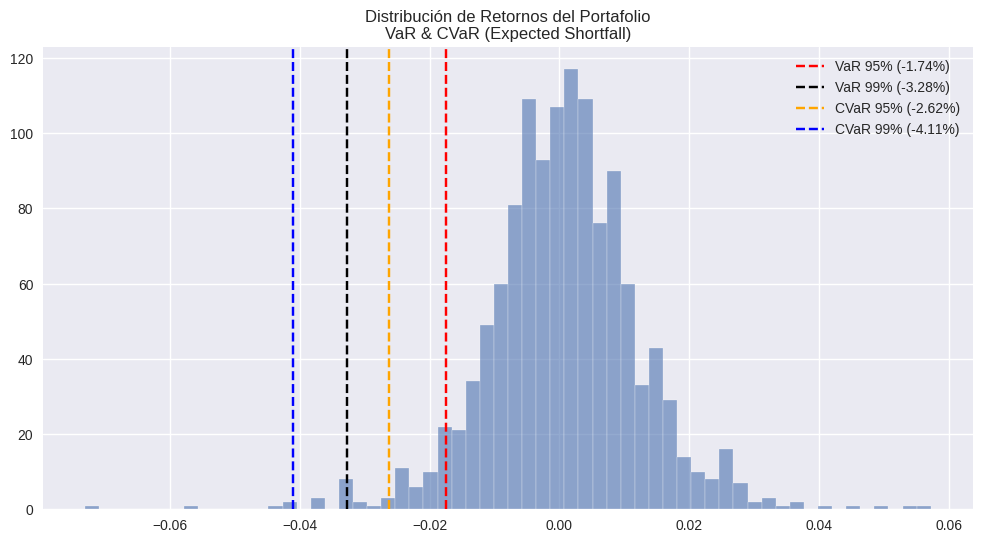

=== KUPIEC BACKTEST (VaR VALIDATION) ===

--- VaR 95% ---
Exceptions: 63
Total days: 1250
Observed proportion: 0.0504
Expected proportion: 0.050000000000000044
LR statistic: 0.00419993166585021
p-value: 0.9483277637016815

--- VaR 99% ---
Exceptions: 13
Total days: 1250
Observed proportion: 0.0104
Expected proportion: 0.010000000000000009
LR statistic: 0.019940589401025763
p-value: 0.8877031364697482

=== ANÁLISIS ===

1. El VaR indica el percentil de pérdida, pero no captura la severidad
   de eventos extremos. Esto se observa en que el CVaR 95% (-2.62%)
   es más negativo que el VaR 95% (-1.74%), confirmando una cola pesada.

2. El CVaR es la medida coherente preferida en FRTB (Basel).
   Captura correctamente el impacto de activos volátiles como BTC y commodities.

3. El Test de Kupiec permite validar si el modelo de VaR está razonablemente
   calibrado. Un p-value bajo (< 0.05) sugiere que el VaR subestima o sobreestima
   el riesgo.

4. La cantidad de excepciones observadas vs esp

In [5]:
# ============================================================
# PROJECT: Historical VaR + CVaR + Kupiec Backtest
# BRANCH: feature/kupiec-backtest
# AUTHOR: Andrés R. (with quant guidance)
# PURPOSE: Version 2.1 of the VaR project
# ============================================================

# ============================================================
# 1. SETUP
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)

# Portafolio multi-activo previamente definido
tickers = ["SPY", "EEM", "IEF", "EURUSD=X", "JPY=X", "GC=F", "BZ=F", "BTC-USD"]
weights = np.array([0.25, 0.10, 0.25, 0.10, 0.05, 0.10, 0.05, 0.10])

start = "2020-12-01"
end   = "2025-12-01"


# ============================================================
# 2. DATA
# ============================================================

print("Descargando datos de mercado...")
raw = yf.download(tickers, start=start, end=end)

# Tomamos solo los precios de cierre
prices = raw.xs('Close', level=0, axis=1).dropna()
print("Datos listos.\n")

# Retornos diarios
returns = prices.pct_change().dropna()

# Retorno del portafolio
portfolio_returns = returns.dot(weights)


# ============================================================
# 3. VALUE AT RISK (VaR) – Historical Method
# ============================================================

def historical_var(series, level=0.95):
    """
    VaR histórico = cuantil empírico.

    REFERENCIA TEÓRICA:
    - John Hull (Risk Management and Financial Institutions)
      Capítulo de Value at Risk.
    - Barbara A. Alexander (Market Risk Analysis)
      Sección sobre "Non-parametric VaR".

    JUSTIFICACIÓN:
    El VaR histórico no asume distribución. Se basa únicamente en los datos
    reales del mercado, lo cual es apropiado para portafolios con activos
    no normales (BTC, commodities, EM).
    """
    return np.percentile(series, (1-level)*100)

VaR_95 = historical_var(portfolio_returns, 0.95)
VaR_99 = historical_var(portfolio_returns, 0.99)

print("=== VaR Histórico ===")
print(f"VaR 95%: {VaR_95:.4%}")
print(f"VaR 99%: {VaR_99:.4%}\n")


# ============================================================
# 4. EXPECTED SHORTFALL (CVaR / ES)
# ============================================================

def historical_cvar(series, level=0.95):
    """
    CVaR (Expected Shortfall) = pérdida promedio condicional
    entre los escenarios que superan (son menores que) el VaR.

    REFERENCIA TEÓRICA:
    - Hull explica que el VaR no informa la magnitud de las pérdidas
      más allá del cuantil: "VaR tells you the threshold, not the severity."
    - Alexander y el marco FRTB del BIS definen el Expected Shortfall como
      la medida coherente de riesgo preferida por regulación.

    PROPIEDAD CLAVE:
    El CVaR es una "coherent risk measure":
    - es subaditiva
    - captura colas pesadas
    - penaliza escenarios extremos severos
    """
    VaR = np.percentile(series, (1-level)*100)
    tail = series[series <= VaR]

    if len(tail) == 0:
        return np.nan

    return tail.mean()

CVaR_95 = historical_cvar(portfolio_returns, 0.95)
CVaR_99 = historical_cvar(portfolio_returns, 0.99)

print("=== Expected Shortfall (CVaR) ===")
print(f"CVaR 95%: {CVaR_95:.4%}")
print(f"CVaR 99%: {CVaR_99:.4%}\n")


# ============================================================
# 5. VISUALIZACIÓN VaR & CVaR
# ============================================================

plt.hist(portfolio_returns, bins=60, alpha=0.6)
plt.axvline(VaR_95, color='red', linestyle='--', label=f'VaR 95% ({VaR_95:.2%})')
plt.axvline(VaR_99, color='black', linestyle='--', label=f'VaR 99% ({VaR_99:.2%})')
plt.axvline(CVaR_95, color='orange', linestyle='--', label=f'CVaR 95% ({CVaR_95:.2%})')
plt.axvline(CVaR_99, color='blue', linestyle='--', label=f'CVaR 99% ({CVaR_99:.2%})')
plt.title("Distribución de Retornos del Portafolio\nVaR & CVaR (Expected Shortfall)")
plt.legend()
plt.show()


# ============================================================
# 6. BACKTEST DEL VaR: Kupiec POF (Proportion of Failures) Test
# ============================================================

def kupiec_test(returns, VaR, level=0.95):
    """
    Kupiec Proportion of Failures Test (POF)

    REFERENCIA TEÓRICA:
    - Hull y Alexander explican que un modelo de VaR debe validarse
      midiendo si el número de excepciones coincide con el nivel esperado.

    INTUICIÓN:
    Si el VaR 95% es correcto, deberíamos observar ≈ 5% de días
    donde la pérdida real supere el VaR (exception).

    FORMALISMO:
    LR = -2 * [ ln((1-p)^(N-X) * p^X) - ln((1-π)^(N-X) * π^X ) ]
    donde:
        p = excepciones observadas / total
        π = 1 - level (excepciones esperadas)
        X = excepciones
        N = total de observaciones

    El estadístico LR ~ χ²(1)
    """
    N = len(returns)
    exceptions = returns < VaR
    X = exceptions.sum()

    p_obs = X / N               # proporción observada
    p_exp = 1 - level           # proporción esperada

    # Likelihood ratio
    # evitar dominio inválido si X=0 o X=N
    if p_obs in [0,1]:
        LR = 0
    else:
        L1 = (p_obs**X) * ((1-p_obs)**(N-X))
        L0 = (p_exp**X) * ((1-p_exp)**(N-X))
        LR = -2 * np.log(L0 / L1)

    p_value = 1 - chi2.cdf(LR, df=1)

    return {
        "Exceptions": int(X),
        "Total days": int(N),
        "Observed proportion": p_obs,
        "Expected proportion": p_exp,
        "LR statistic": LR,
        "p-value": p_value
    }

kupiec_95 = kupiec_test(portfolio_returns, VaR_95, level=0.95)
kupiec_99 = kupiec_test(portfolio_returns, VaR_99, level=0.99)

print("=== KUPIEC BACKTEST (VaR VALIDATION) ===")
print("\n--- VaR 95% ---")
for k,v in kupiec_95.items():
    print(f"{k}: {v}")

print("\n--- VaR 99% ---")
for k,v in kupiec_99.items():
    print(f"{k}: {v}")


# ============================================================
# 7. ANÁLISIS INSTITUCIONAL
# ============================================================

print("\n=== ANÁLISIS ===")
print(f"""
1. El VaR indica el percentil de pérdida, pero no captura la severidad
   de eventos extremos. Esto se observa en que el CVaR 95% ({CVaR_95:.2%})
   es más negativo que el VaR 95% ({VaR_95:.2%}), confirmando una cola pesada.

2. El CVaR es la medida coherente preferida en FRTB (Basel).
   Captura correctamente el impacto de activos volátiles como BTC y commodities.

3. El Test de Kupiec permite validar si el modelo de VaR está razonablemente
   calibrado. Un p-value bajo (< 0.05) sugiere que el VaR subestima o sobreestima
   el riesgo.

4. La cantidad de excepciones observadas vs esperadas es esencial.
   Institucionalmente, un VaR que falla demasiado frecuentemente implica
   que el modelo es peligroso y necesita revisión.

""")
